# Identify key taxa and fluxes enabling phenotype predictions

In [53]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import sklearn
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def match_Xy_df(X_in_df, y_in_df):
    X_df, y_df = X_in_df.copy(), y_in_df.copy()
    """ Makes sure X_df and y_df have the same indices"""
    overlap = list(set(X_df.index).intersection(set(y_df.index)))
    X_df =  X_df.loc[overlap]
    y_df =  y_df.loc[overlap]
    return X_df, y_df


def get_imp_feature_series(X, n_scores, FEAT_FILTER_TYPE, phenotype, input_type):
    feat_df = pd.DataFrame()

    for est_i in range(len(n_scores["estimator"])):
        if FEAT_FILTER_TYPE == "SelectKBest":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].get_support()],name=est_i)
        elif FEAT_FILTER_TYPE == "RFE":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].support_],name=est_i)
        feat_df = pd.concat([feat_df, feat_series_df],axis=1)

    feat_df.fillna(0, inplace=True)
    feat_df_avg = feat_df.mean(axis=1)
    feat_df_avg.name = phenotype+"_"+input_type
    return feat_df_avg


def drop_constant_cols(df):
    """Get rid of sklearn warnings that say there are constant columns..."""
    df = df.loc[:, (df != df.iloc[0]).any()]
    return df


def drop_lowstd_cols(df,std_cutoff=1e-5):
    """Get rid of sklearn warnings that say there are constant columns..."""
    df = df.loc[:, abs(df.std())>std_cutoff]
    return df

# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'
# DATA_LOC = '../../Data/microbiome_xai/'

# FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"

SAVE_FIG = True

gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)
X_flux = drop_constant_cols(X_flux)
# X_flux = drop_lowstd_cols(X_flux,std_cutoff=1e-4)

food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
food_matrix_df.index = food_matrix_df.index.map(lambda x: "EX_"+x.replace("[e]", "_m__medium"))

Fixed EX_tDHNACOA(e)


In [54]:
X_flux.shape

(9285, 271)

In [ ]:
X_flux.loc[:, (X_flux != df.iloc[0]).any()]

# Pairwise associations

In [ ]:
gut_data.set_ibd_df(sample_num=10000, add_other_diagnosis=False)
gut_data.y_df.sum()

In [16]:
input_type = "flux"#"abundance" # "flux"#"abundance"#"flux"

gut_data.set_vegan_df(sample_num=10000)
# gut_data.set_ibs_df(sample_num=10000, add_other_diagnosis=False)

SCALE_TYPE=StandardScaler()
y_df = gut_data.y_df.copy()
if input_type=="flux":
    X, y = match_Xy_df(X_flux.copy(), y_df)
elif input_type=="abundance":
    X, y = match_Xy_df(gut_data.X_df.copy(), y_df)

X_scale = SCALE_TYPE.fit_transform(X)
f_stat, p_val = f_classif(X_scale, y)
#fclass_df = pd.DataFrame(f_stat, index=X.columns, columns=["f_stat"])
fclass_pval_df = pd.Series(p_val, index=X.columns)
fclass_pval_df.name = "pval"
# fclass_df = pd.DataFrame([f_stat, p_val], index=X.columns, columns=["f_stat", "p_val"])
fclass_pval_df.sort_values()

EX_4hpro_LT_m__medium      0.000288
EX_glcmannan_m__medium     0.000467
EX_h2s_m__medium           0.001496
EX_dad_2_m__medium         0.004576
EX_glu_L_m__medium         0.004867
                             ...   
EX_starch1200_m__medium    0.951924
EX_xylan_m__medium         0.958877
EX_diact_m__medium         0.965045
EX_srb_L_m__medium         0.990930
EX_acetone_m__medium       0.991765
Name: pval, Length: 788, dtype: float64

In [7]:
fclass_pval_df.sort_values()[:20]

EX_4hpro_LT_m__medium       0.000288
EX_glcmannan_m__medium      0.000467
EX_h2s_m__medium            0.001496
EX_dad_2_m__medium          0.004576
EX_glu_L_m__medium          0.004867
EX_tlf_a_m5_m__medium       0.004994
EX_gln_L_m__medium          0.005129
EX_inulin_m__medium         0.007419
EX_fru_m__medium            0.009870
EX_arab_D_m__medium         0.018093
EX_hspg_degr_6_m__medium    0.019499
EX_alaglu_m__medium         0.024966
EX_cbl2_m__medium           0.031922
EX_man6p_m__medium          0.037070
EX_ppoh_m__medium           0.039244
EX_hspg_degr_3_m__medium    0.039344
EX_gsn_m__medium            0.042191
EX_met_L_m__medium          0.050556
EX_n2_m__medium             0.057570
EX_mannan_m__medium         0.062549
Name: pval, dtype: float64

In [13]:
X["EX_ind3ppa_m__medium"]#.mean()

10317.000006757    5.021821e-09
10317.000013026    4.854560e-08
10317.000050236    1.024107e-07
10317.000097212    2.350380e-09
10317.000033697    6.594596e-08
                       ...     
10317.000067744    4.755675e-09
10317.000076535    2.219724e-08
10317.000090017    5.120266e-09
10317.000078799    8.701602e-10
10317.000074426    1.710872e-10
Name: EX_ind3ppa_m__medium, Length: 7090, dtype: float64

In [14]:
gut_data.y_df[gut_data.y_df==1].index

Index(['10317.000083166', '10317.000072584', '10317.000083164',
       '10317.000050324', '10317.000035445', '10317.000006879',
       '10317.000076639', '10317.000047235', '10317.000067792',
       '10317.000048344',
       ...
       '10317.000022512', '10317.000072161', '10317.000072036',
       '10317.000092868', '10317.000030122', '10317.000068106',
       '10317.000090534', '10317.000023250', '10317.000079807',
       '10317.000093564'],
      dtype='object', name='sample_name', length=166)

In [18]:
X.loc[y_df[y_df==1].index]

KeyError: "['10317.000005918'] not in index"

In [19]:
react_ids = ["EX_ind3ppa_m__medium"]
print(X[react_ids].mean().sort_values())
print("yes:",X[react_ids].loc[y[y==1].index].mean().sort_values())

EX_ind3ppa_m__medium    9.638998e-08
dtype: float64
yes: EX_ind3ppa_m__medium    7.781745e-08
dtype: float64


In [20]:
react_ids = ["EX_ind3ppa_m__medium"]
print(X[react_ids].mean().sort_values())
print("yes:",X[react_ids].loc[y[y==1].index].mean().sort_values())
print("no:",X[react_ids].loc[y[y==0].index].mean().sort_values())

EX_ind3ppa_m__medium    9.638998e-08
dtype: float64
yes: EX_ind3ppa_m__medium    7.781745e-08
dtype: float64
no: EX_ind3ppa_m__medium    9.683251e-08
dtype: float64


In [31]:
feat_id = "bacteroides"#"clostridioides"#"butyricicoccus"
col_yes = X.loc[y[y==1].index][feat_id]
col_no = X.loc[y[y==0].index][feat_id]
print(col_yes.mean(), col_no.mean())

3929.620481927711 4746.854281280857


In [27]:
col_yes.mean()

75.91566265060241

In [ ]:
SAMPLE_NUM = 200
gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
X_flux_vegan, y_vegan_df = match_Xy_df(X_flux.copy(), gut_data.y_df)
# X_flux_vegan = mb_utils.scale_inputs(X_flux_vegan, pd_bool=True)
X_flux_vegan["vegan"] = y_vegan_df
## Convert to long
X_flux_vegan_long = X_flux_vegan.copy()
X_flux_vegan_long = X_flux_vegan_long.reset_index()

top_feats_df = get_top_df(imp_feat_flux_pheno_df,  col="vegan_flux",n_feats=5)
top_feats = top_feats_df.index

X_flux_vegan_long = pd.melt(
    X_flux_vegan_long, id_vars=["index","vegan"], 
    value_vars=top_feats
    #[
        #"EX_thr_L_m__medium", 
        # "EX_cgly_m__medium",
        # "EX_lcts_m__medium", "EX_isobut_m__medium", "EX_pect_m__medium"
        # "EX_salcn_m__medium", 
        # "EX_isocapr_m__medium", "EX_pcresol_m__medium"
        #]
        )
# sns.barplot(x="variable",y="value",hue="vegan",data=X_flux_vegan_long)
# sns.barplot(y="variable",x="value",hue="vegan",data=X_flux_vegan_long)
sns.boxplot(y="variable",x="value",hue="vegan",data=X_flux_vegan_long)

In [22]:
fclass_pval_df.sort_values()[:10]

clostridioides       6.153178e-11
anaerosporobacter    1.049962e-05
anaeroplasma         1.451047e-04
butyricicoccus       2.153863e-04
coprococcus          6.681058e-04
bilophila            1.047634e-03
lachnospira          2.620512e-03
alistipes            2.875740e-03
marvinbryantia       2.892381e-03
nk4a214              3.181216e-03
Name: pval, dtype: float64

In [5]:
SCALE_TYPE=StandardScaler()
X_scale = SCALE_TYPE.fit_transform(X)

In [9]:
X_scale

array([[ 0.42619115, -0.14235031, -0.08701954, ...,  1.4955528 ,
        -0.07520616, -0.10375201],
       [-0.33409086, -0.14235031, -0.08701954, ..., -0.27206487,
        -0.07520616, -0.10375201],
       [-0.22495242, -0.14235031, -0.08701954, ..., -0.27206487,
        -0.07520616, -0.10375201],
       ...,
       [-0.28984555, -0.14235031, -0.08701954, ..., -0.27206487,
        -0.07520616, -0.07112393],
       [ 0.00512323, -0.14235031, -0.08701954, ..., -0.27206487,
        -0.07520616, -0.0533268 ],
       [-0.09590358, -0.14235031, -0.08701954, ..., -0.27206487,
        -0.07520616, -0.05925918]])

In [16]:
gut_data.set_t2d_df(sample_num=10000, add_other_diagnosis=False)
gut_data.y_df.sum()

179

In [ ]:
gut_data.set_ibs_df(sample_num=10000, add_other_diagnosis=False)
gut_data.y_df.sum()

In [ ]:

food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
food_matrix_df.index = food_matrix_df.index.map(lambda x: "EX_"+x.replace("[e]", "_m__medium"))
# metab_overlap = list(set(X_flux.columns).intersection(set(food_matrix_df.index)))
# print(len(metab_overlap))
# X_flux = X_flux[metab_overlap]

In [ ]:
# consumption_reacts = X_flux.max()[X_flux.max()<=0].index # X_flux.min()[X_flux.min()<0]
# X_flux = X_flux[consumption_reacts].copy()

In [5]:
FILE_SAV = '../../../Data/microbiome_xai/micom-sim-data/ml_params_fd_PARALLEL_top5.csv'
ml_params_df_sheet = pd.read_csv(FILE_SAV, index_col=0)

for phenotype in ["vegan", "ibs"][:]:
    for input_type in ["flux", "abundance"][:]:
        sheet_name = phenotype+"_"+input_type
        pheno_input_df = ml_params_df_sheet[ml_params_df_sheet["pheno_input"]==sheet_name].copy()
        best_params = pheno_input_df.sort_values("roc_auc",ascending=False).iloc[0]
        # print(best_params)
        C_PARAM = best_params["reg_val"]
        N_FEATURES = best_params["n_features"]
        PENALTY_PARAM = best_params["reg_type"] 
        FEAT_FILTER_TYPE = 'SelectKBest'
        print(input_type, C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
        

flux 0.01 100 l2 SelectKBest
abundance 0.1 75 l1 SelectKBest
flux 0.1 15 l1 SelectKBest
abundance 10.0 75 l2 SelectKBest


In [ ]:
# ml_params_df = pd.read_excel(io=DATA_LOC+"ml_params.xlsx")
ml_best_params_dict = {}
phenotype = "ibs"
input_type = "flux"
for phenotype in ["vegan", "ibs"][:]:
    for input_type in ["flux", "abundance"][:]:
        sheet_name = phenotype+"_"+input_type
        ml_params_df_sheet = pd.read_excel(io=gut_data.dir_sim_data+"ml_params.xlsx", sheet_name=sheet_name, index_col=[0,1,2])
        ml_params_df_sheet.sort_values(["balanced_accuracy", "roc_auc"],ascending=False,inplace=True)
        (C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE) = ml_params_df_sheet.index[0]
        # (C_PARAM, N_FEATURES, PENALTY_PARAM) = ml_params_df_sheet.index[0]
        print(C_PARAM, N_FEATURES, PENALTY_PARAM)
        ml_best_params_dict.update({sheet_name: {
            "C_PARAM":C_PARAM, "N_FEATURES": N_FEATURES, "PENALTY_PARAM": PENALTY_PARAM, "FEAT_FILTER_TYPE": FEAT_FILTER_TYPE}})
        # ml_params_df_sheet

In [26]:
#for phenotype in ["vegan", "ibs", "t2d", "ibd"][:]: #  "ibs", "t2d", "ibd" # not enough samples for t2d and ibd
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
)
gut_data.norm_abundances(filter_model=False, add_delta=True) ## Filters genus to those in model, adds small value to abundaces

# gut_data.set_t2d_df(sample_num=10000, add_other_diagnosis=False)
# gut_data.set_vegan_df(sample_num=10000)
# gut_data.set_ibs_df(sample_num=10000, add_other_diagnosis=False)
gut_data.set_ibd_df(sample_num=10000, add_other_diagnosis=False)
print(gut_data.X_df.shape, gut_data.y_df.sum(), gut_data.X_df.shape[0]-gut_data.y_df.sum())

Fixed EX_tDHNACOA(e)
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
(8569, 133) 390 8179


In [25]:
gut_data.set_ibd_df(sample_num=10000, add_other_diagnosis=False)
print(gut_data.X_df.shape, gut_data.y_df.sum(), gut_data.X_df.shape[0]-gut_data.y_df.sum())

(8569, 133) 390 8179


In [55]:
SAVE_ID = "PARALLEL_std-4_noparams_5_75"#"PARALLEL"#"stdscale", "maxmin" # "minmax"

N_SPLITS = 50 #10
TEST_SIZE = 0.25
SAMPLE_NUM = 10000

# C_PARAM = 1000
C_PARAM = 5
PENALTY_PARAM = "l2"#"l2"
FEAT_FILTER_TYPE = 'SelectKBest' # "RFE" #"SelectKBest"
N_FEATURES = 75
# SCALE_TYPE = StandardScaler()# MinMaxScaler()# StandardScaler() #StandardScaler() #MinMaxScaler()
SCALE_TYPE = StandardScaler() #MinMaxScaler()

LOAD_ML_PARAMS = True
ONLY_FOOD_METABS = False

FILE_SAV = '../../../Data/microbiome_xai/micom-sim-data/ml_params_fd_PARALLEL_top5.csv'
ml_params_df_sheet = pd.read_csv(FILE_SAV, index_col=0)

if ONLY_FOOD_METABS==True: ## CAREFUL... IF SET THEN X_flux is changed!!!
    metab_overlap = list(set(X_flux.columns).intersection(set(food_matrix_df.index)))
    print(len(metab_overlap))
    X_flux = X_flux[metab_overlap]
    SAVE_ID = "foodmetabs"

imp_feat_flux_pheno_df, imp_feat_abundance_pheno_df = pd.DataFrame(), pd.DataFrame()
flux_pheno_direct_df = pd.DataFrame()
input_type_aucs_long = pd.DataFrame()

for phenotype in ["vegan", "ibs","t2d", "ibd"]:
    gut_data.norm_abundances(filter_model=False, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
    gut_data.X_df = gut_data.asv_df.T.copy()
    #print(gut_data.X_df.shape)
    #print(gut_data.X_df.iloc[:5,:3])
    gut_data.sample_list = gut_data.X_df.index.to_list()

    if phenotype=="vegan":
        gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
    elif phenotype=="ibs":
        gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif phenotype=="t2d":
        gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif phenotype=="ibd":
        gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    # print("gut_data.X_df.shape after set_pheno_df:",gut_data.X_df.shape)
    score_list = ['accuracy','balanced_accuracy','roc_auc','average_precision', 'f1', 'f1_weighted']

    ml_data_dict = {}
    for input_type in ["flux", "abundance"][:]:

        ### Load best ML parameters
        if LOAD_ML_PARAMS==True:
            # sheet_name = phenotype+"_"+input_type
            # ml_params_df_sheet = pd.read_excel(io=gut_data.dir_sim_data+"ml_params.xlsx", sheet_name=sheet_name, index_col=[0,1,2,3])
            # ml_params_df_sheet.sort_values(["balanced_accuracy", "roc_auc"],ascending=False,inplace=True)
            # (C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE) = ml_params_df_sheet.index[0]
            # # (C_PARAM, N_FEATURES, PENALTY_PARAM) = ml_params_df_sheet.index[0]
            # print(sheet_name, C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
            
            sheet_name = phenotype+"_"+input_type
            pheno_input_df = ml_params_df_sheet[ml_params_df_sheet["pheno_input"]==sheet_name].copy()
            best_params = pheno_input_df.sort_values("roc_auc",ascending=False).iloc[0]
            C_PARAM = best_params["reg_val"]
            N_FEATURES = best_params["n_features"]
            PENALTY_PARAM = best_params["reg_type"] 
            FEAT_FILTER_TYPE = 'SelectKBest'
            SCALE_TYPE_ = best_params["norm_type"] 
            print(phenotype, input_type, best_params["roc_auc"], C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
            
            if sheet_name == "t2d_flux":
                FEAT_FILTER_TYPE = 'SelectKBest'
                C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 0.1, 75, "l2", "StandardScaler"
                print("CHANGED TO...",phenotype, input_type, best_params["roc_auc"], C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
            if sheet_name == "vegan_flux":
                FEAT_FILTER_TYPE = 'SelectKBest'
                # C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 10, 100, "l2", "StandardScaler"
                C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 5, 40, "l2", "StandardScaler"
                print("CHANGED TO...",phenotype, input_type, best_params["roc_auc"], C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
            if sheet_name == "ibd_flux":
                FEAT_FILTER_TYPE = 'SelectKBest'
                # C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 10, 100, "l2", "StandardScaler"
                C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 5, 40, "l2", "StandardScaler"
                print("CHANGED TO...",phenotype, input_type, best_params["roc_auc"], C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)
            if sheet_name == "ibs_flux":
                FEAT_FILTER_TYPE = 'SelectKBest'
                # C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 10, 100, "l2", "StandardScaler"
                C_PARAM, N_FEATURES, PENALTY_PARAM, SCALE_TYPE_ = 5, 40, "l2", "StandardScaler"
                print("CHANGED TO...",phenotype, input_type, best_params["roc_auc"], C_PARAM, N_FEATURES, PENALTY_PARAM, FEAT_FILTER_TYPE)

        gut_data.logreg.C = C_PARAM
        gut_data.logreg.penalty = PENALTY_PARAM

        y_df = gut_data.y_df.copy()
        if input_type=="flux":
            X, y = match_Xy_df(X_flux.copy(), y_df)
        elif input_type=="abundance":
            X, y = match_Xy_df(gut_data.X_df.copy(), y_df)
            
        # X = mb_utils.filter_X_cols(X)
        # X, y = X.values, y.values

        if FEAT_FILTER_TYPE=="SelectKBest":
            feat_filter = SelectKBest(f_classif, k=N_FEATURES)
        elif FEAT_FILTER_TYPE=="RFE":
            feat_filter = RFE(estimator=gut_data.logreg, n_features_to_select=N_FEATURES)
            
        if SCALE_TYPE_ =="StandardScaler":
            SCALE_TYPE=StandardScaler()
        elif SCALE_TYPE_ =="MinMaxScaler":
            SCALE_TYPE=MinMaxScaler()
        
        skf = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE)
        model = make_pipeline(SCALE_TYPE, SMOTE(), feat_filter, gut_data.logreg)
        # model = make_pipeline(SMOTE(), feat_filter, gut_data.logreg)
        # model = make_pipeline(StandardScaler(), RandomOverSampler(), feat_filter, gut_data.logreg)
        n_scores = cross_validate(model, X, y, scoring=score_list, cv=skf, n_jobs=-1, error_score='raise', return_estimator=True)
        score_dict = {score_id: n_scores["test_"+score_id] for score_id in score_list}

        imp_feat_df = get_imp_feature_series(X, n_scores, FEAT_FILTER_TYPE, phenotype, input_type)
        if input_type=="flux":
            imp_feat_flux_pheno_df = pd.concat([imp_feat_flux_pheno_df,imp_feat_df],axis=1)

            flux_direction_dict = {}
            flux_direction_dict[input_type+"_"+phenotype] = {}
            for rxn in imp_feat_df.index:
                flux_sign = imp_feat_df.loc[rxn]*np.sign(X[rxn].loc[y[y==1].index].mean())
                flux_direction_dict[input_type+"_"+phenotype].update({rxn: flux_sign})
            flux_pheno_direct_df = pd.concat([flux_pheno_direct_df, pd.DataFrame(flux_direction_dict)],axis=1)

        elif input_type=="abundance":
            imp_feat_abundance_pheno_df = pd.concat([imp_feat_abundance_pheno_df,imp_feat_df],axis=1)

        ml_data_dict.update({
            input_type: score_dict
        })

    ### GET DUMMY ESTIMATES
    model = sklearn.dummy.DummyClassifier(strategy='uniform')
    n_scores = cross_validate(model, X, y, scoring=score_list, cv=skf, n_jobs=-1, error_score='raise', return_estimator=True)
    score_dict = {score_id: n_scores["test_"+score_id] for score_id in score_list}
    ml_data_dict.update({
            "dummy_uniform": score_dict
    })
    
    model = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    n_scores = cross_validate(model, X, y, scoring=score_list, cv=skf, n_jobs=-1, error_score='raise', return_estimator=True)
    score_dict = {score_id: n_scores["test_"+score_id] for score_id in score_list}
    ml_data_dict.update({
            "dummy_frequent": score_dict
    })
    
    ### Gather results into long dataset type
    ml_data_df = pd.DataFrame.from_dict(ml_data_dict,orient="index")
    ml_data_df.reset_index(inplace=True)
    ml_data_df_long = ml_data_df.explode("roc_auc",ignore_index=True)[["index","roc_auc"]]
    for col in ["balanced_accuracy", "average_precision","f1", "f1_weighted"]:
        ml_data_df_long = pd.concat([ml_data_df_long, ml_data_df.explode(col,ignore_index=True)[col]],axis=1)

    ml_data_df_long["roc_auc"] = ml_data_df_long["roc_auc"].astype(float)
    ml_data_df_long["phenotype"] = phenotype
    input_type_aucs_long = pd.concat([input_type_aucs_long, ml_data_df_long])
        
input_type_aucs_long.to_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID))
imp_feat_abundance_pheno_df.to_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID))
flux_pheno_direct_df.to_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID))
imp_feat_flux_pheno_df.to_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID))

... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
vegan flux 0.6044372782065003 0.01 100 l2 SelectKBest
CHANGED TO... vegan flux 0.6044372782065003 5 40 l2 SelectKBest
vegan abundance 0.7299290260800991 0.1 75 l1 SelectKBest
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
ibs flux 0.5557439890370001 0.1 15 l1 SelectKBest
CHANGED TO... ibs flux 0.5557439890370001 5 40 l2 SelectKBest
ibs abundance 0.5877329326024667 10.0 75 l2 SelectKBest
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
t2d flux 0.5681262487512487 100.0 100 l1 SelectKBest
CHANGED TO... t2d flux 0.5681262487512487 0.1 75 l2 SelectKBest
t2d abundance 0.6708008658008657 1000.0 20 l2 SelectKBest
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
ibd flux 0.6948562446983684 10.0 100 l2 SelectKBest
CHANGED TO... ibd flux 0.6948562446983684 5 40 l2 SelectKBest
ibd abun

vegan (7090, 133)

ibs (6501, 133)

t2d (8569, 133)

In [10]:
print(gut_data.X_df.iloc[:5,:3])

                      NaN  acidaminococcus  acinetobacter
10317.000029186  0.103371         0.000057       0.000057
10317.000048303  0.022124         0.000057       0.000057
10317.000079162  0.012493         0.000057       0.000057
10317.000076743  0.104431         0.000057       0.000057
10317.000093087  0.012394         0.001104       0.000057


In [89]:
print(gut_data.X_df.shape, gut_data.y_df.shape)

(8569, 133) (8569,)


In [109]:
NO_DUMMY=True
performance_dict = {}
performance_table = pd.DataFrame()
score_ids = ["balanced_accuracy", "average_precision","f1", "f1_weighted"]
for grp_id, grp in input_type_aucs_long.groupby("phenotype"):
    for input_id, input_grp in grp.groupby("index"):
        if NO_DUMMY==True and "dummy" not in input_id:
            # print(input_grp.head())
            df = input_grp.describe().loc[["mean","std"]].T.copy()
            df = df.round(decimals=2).apply(lambda x: '±'.join(x.astype(str)),axis=1)
            df.name = grp_id+"_"+input_id
            #performance_table = pd.concat([performance_table
            performance_table = performance_table.append(df)
        
performance_table.to_csv(gut_data.dir_sim_data+'performance_table_%s_fd.csv'%(SAVE_ID))
performance_table

,roc_auc
ibd_abundance,0.75±0.02
ibd_flux,0.67±0.02
ibs_abundance,0.58±0.01
ibs_flux,0.54±0.02
t2d_abundance,0.63±0.06
t2d_flux,0.55±0.04
vegan_abundance,0.71±0.04
vegan_flux,0.59±0.06


In [73]:
performance_table

,roc_auc
ibd_abundance,0.74±0.03
ibd_flux,0.65±0.02
ibs_abundance,0.56±0.01
ibs_flux,0.55±0.02
t2d_abundance,0.63±0.03
t2d_flux,0.55±0.04
vegan_abundance,0.67±0.05
vegan_flux,0.59±0.04


In [ ]:
SAVE_FIG = True

# Plot performance tables and figures

In [58]:
# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
# SAVE_ID = "stdscale_50feats_c1"#"stdscale", "maxmin" # "minmax"
# SAVE_ID = "PARALLEL"
# SAVE_ID = "PARALLEL_std"
# SAVE_ID = "PARALLEL_std_noparams_5_100"
SAVE_ID = "PARALLEL_std-4_noparams_5_75"

# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance.csv', index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance.csv', index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux.csv', index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction.csv', index_col=0)

input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)

In [59]:
NO_DUMMY=True
performance_dict = {}
performance_table = pd.DataFrame()
score_ids = ["balanced_accuracy", "average_precision","f1", "f1_weighted"]
for grp_id, grp in input_type_aucs_long.groupby("phenotype"):
    for input_id, input_grp in grp.groupby("index"):
        if NO_DUMMY==True and "dummy" not in input_id:
            # print(input_grp.head())
            df = input_grp.describe().loc[["mean","std"]].T.copy()
            df = df.round(decimals=2).apply(lambda x: '±'.join(x.astype(str)),axis=1)
            df.name = grp_id+"_"+input_id
            #performance_table = pd.concat([performance_table
            performance_table = performance_table.append(df)
        
performance_table.to_csv(gut_data.dir_sim_data+'performance_table_%s_fd.csv'%(SAVE_ID))
performance_table
            

,roc_auc,balanced_accuracy,average_precision,f1,f1_weighted
ibd_abundance,0.75±0.02,0.7±0.02,0.28±0.03,0.2±0.01,0.84±0.01
ibd_flux,0.67±0.03,0.63±0.03,0.14±0.03,0.15±0.01,0.8±0.02
ibs_abundance,0.58±0.02,0.56±0.01,0.19±0.01,0.26±0.01,0.62±0.01
ibs_flux,0.51±0.02,0.5±0.01,0.15±0.01,0.23±0.01,0.53±0.04
t2d_abundance,0.65±0.04,0.61±0.03,0.05±0.01,0.06±0.01,0.78±0.02
t2d_flux,0.5±0.04,0.51±0.04,0.02±0.0,0.04±0.01,0.72±0.03
vegan_abundance,0.73±0.04,0.68±0.03,0.07±0.02,0.1±0.01,0.83±0.01
vegan_flux,0.58±0.04,0.56±0.04,0.04±0.01,0.05±0.01,0.72±0.02


/home/eskavvas/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/eskavvas/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/eskavvas/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/eskavvas/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/eskavvas/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


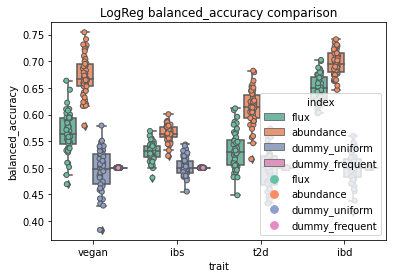

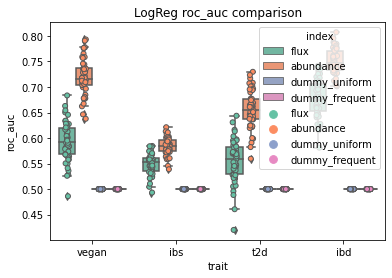

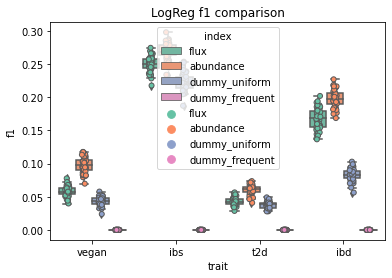

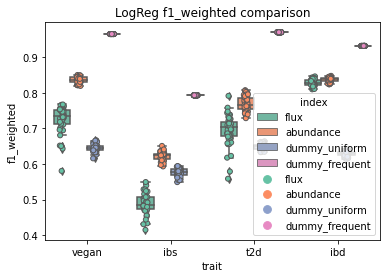

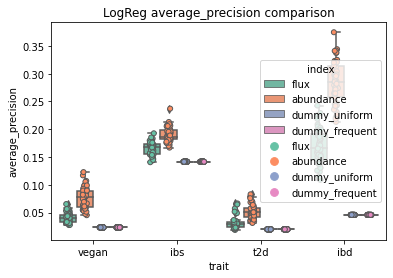

In [17]:
for ml_metric in ["balanced_accuracy", "roc_auc", "f1", "f1_weighted", "average_precision"]:
    f, ax = plt.subplots()
    ax = sns.boxplot(x="phenotype", y=ml_metric, hue="index", data=input_type_aucs_long, palette="Set2")
    ax = sns.stripplot(x="phenotype", y=ml_metric, hue="index", data=input_type_aucs_long, color=".25",  
        split=True, jitter=True,palette="Set2",linewidth=1,edgecolor='gray')
    # ax = sns.swarmplot(x="phenotype", y="roc_auc", hue="index", data=input_type_aucs_long, color=".25",  split=True, palette="Set2",edgecolor='gray')
    # ax.set_ylabel("features")
    ax.set_xlabel("trait")
    ax.set_title("LogReg %s comparison"%(ml_metric))

    if SAVE_FIG == True:
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_comparison.svg"%(ml_metric))
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_comparison.png"%(ml_metric))

# Feature Importance Plots

`flux_pheno_direct_df` accounts for direction of flux reaction (average of flux in positive samples)

In [33]:
from collections import Counter

def get_top_df(input_df, col, n_feats=10):
    """
    input_df: imp_feat_flux_pheno_df or imp_feat_abundance_pheno_df
    col: vegan_flux
    """
    top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
    top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
    top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
    top_df['positive'] = top_df[col] > 0
    return top_df

def reindex_metab_id2name(in_df, gut_data):
    in_df.index = in_df.index.map(lambda x: gut_data.com_model.metabolites.get_by_id(x).name)
    return in_df

In [34]:
# metab_info_df = pd.read_csv(DATA_LOC+"agp_data/recon_metabolites_food_therapeutic_disease_df.csv", index_col=0)
metab_info_df = pd.read_csv(DATA_LOC+"agp_data/metab_info_food_df.csv", index_col=0)
metab_info_df.head()

,id,name,formula,extracellular,abbreviation,food_db,pubChemId,ctdID,diseaseNames_therapeutic,diseaseNames_disease,food_db_id,foods
0,rsvgluc[p],rosuvastatin-glucuronide,C56H70CaF2N6O24S2,False,rsvgluc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5pmev[c],(R)-5-phosphonatomevalonate(3-),C6H10O7P,False,5pmev,FDB022566,439400.0,NaN,NaN,NaN,22566.0,[]
2,sfnd_1689_glc[e],Nw 1689 Acyl Glucuronide,C20H18FO9,True,sfnd_1689_glc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6ohfvs[p],6-hydroxy-fluvastatin,C24H25FNNaO5,False,6ohfvs,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,man6p[e],D-Mannose 6-phosphate,C6H11O9P,True,man6p,FDB022411,439198.0,NaN,NaN,NaN,22574.0,[]


In [57]:
# SAVE_ID = "maxmin"#"stdscale"
# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
SAVE_ID = "PARALLEL"

# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance.csv', index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance.csv', index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux.csv', index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction.csv', index_col=0)

# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s.csv'%(SAVE_ID), index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s.csv'%(SAVE_ID), index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s.csv'%(SAVE_ID), index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s.csv'%(SAVE_ID), index_col=0)

input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)

For below code, different dataframes provide different index names for the fluxes

In [35]:
imp_feat_flux_pheno_df_metab = imp_feat_flux_pheno_df.copy()
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "_m"))
imp_feat_flux_pheno_df_metab["name"] = imp_feat_flux_pheno_df_metab.index.map(lambda x: gut_data.com_model.metabolites.get_by_id(x).name)
imp_feat_flux_pheno_df_metab = reindex_metab_id2name(imp_feat_flux_pheno_df_metab, gut_data)
imp_feat_flux_pheno_df_metab.drop("name",inplace=True,axis=1)
imp_feat_flux_pheno_df_metab.sort_values("vegan_flux",ascending=False)
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x[:30] if len(x) > 25 else x)
imp_feat_flux_pheno_df_metab

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
2-Oxobutanoate,0.408264,NaN,-0.004030,NaN
protein-linked serine or threo,-0.919420,NaN,0.264935,-0.005451
N-acetylneuraminate,-0.155443,NaN,-0.109586,NaN
L-alanyl-L-glutamate,-0.015096,0.026521,-0.026434,NaN
L-alanyl-L-leucine,0.020963,NaN,-0.072404,0.020134
...,...,...,...,...
Propranolol,NaN,NaN,0.001464,NaN
Phenylpropanoate,NaN,NaN,0.004329,NaN
Thiamin monophosphate,NaN,NaN,0.004367,NaN
Sulfanilamide,NaN,NaN,-0.013804,NaN


# Heatmap

In [51]:
top_feats_df = get_top_df(imp_feat_flux_pheno_df,  col="vegan_flux",n_feats=10)
# top_feats_df = get_top_df(imp_feat_flux_pheno_df_metab,  col="vegan_flux",n_feats=10)
# top_feats_df

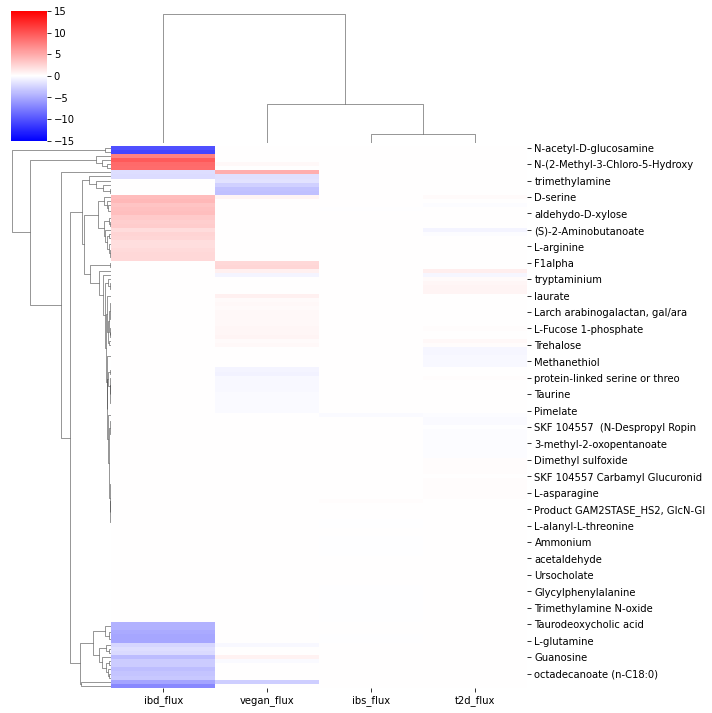

In [52]:
n_feats = 20
top_heatmap_df = pd.DataFrame()
for i, col in enumerate(imp_feat_flux_pheno_df.columns): # loop through flux_pheno
    top_df = get_top_df(imp_feat_flux_pheno_df_metab, col, n_feats=n_feats) # uses metab df for IDS or names
    top_heatmap_df = pd.concat([top_heatmap_df, top_df[[col]]],axis=1)

sns.clustermap(top_heatmap_df.fillna(0), cmap="bwr", vmin=-15, vmax=15)

In [17]:
abs(imp_feat_abundance_pheno_df.values).max()

nan

In [ ]:
n_feats = 20
top_heatmap_df = pd.DataFrame()
for i, col in enumerate(imp_feat_abundance_pheno_df.columns): # loop through flux_pheno
    top_df = get_top_df(imp_feat_abundance_pheno_df, col, n_feats=n_feats) # uses metab df for IDS or names
    top_heatmap_df = pd.concat([top_heatmap_df, top_df[[col]]],axis=1)

sns.clustermap(top_heatmap_df.fillna(0), cmap="bwr", 
               vmin=-abs(imp_feat_abundance_pheno_df.values).max(), 
               vmax=abs(imp_feat_abundance_pheno_df.values).max(),
               figsize=(5,13))

In [ ]:
gut_data.com_model.metabolites.get_by_id("drib_m")

# Barplots of Features

In [60]:
# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
# SAVE_ID = "stdscale_50feats_c1"#"stdscale", "maxmin" # "minmax"
# SAVE_ID = "PARALLEL"
# SAVE_ID = "PARALLEL_std"
# SAVE_ID = "PARALLEL_std_noparams"
SAVE_ID = "PARALLEL_std-4_noparams_5_75"
# SAVE_ID = "PARALLEL_std_noparams_5_100"
# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance.csv', index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance.csv', index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux.csv', index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction.csv', index_col=0)

input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)

imp_feat_flux_pheno_df_metab = imp_feat_flux_pheno_df.copy()
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "_m"))
imp_feat_flux_pheno_df_metab["name"] = imp_feat_flux_pheno_df_metab.index.map(lambda x: gut_data.com_model.metabolites.get_by_id(x).name)
imp_feat_flux_pheno_df_metab = reindex_metab_id2name(imp_feat_flux_pheno_df_metab, gut_data)
imp_feat_flux_pheno_df_metab.drop("name",inplace=True,axis=1)
imp_feat_flux_pheno_df_metab.sort_values("vegan_flux",ascending=False)
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x[:30] if len(x) > 25 else x)
imp_feat_flux_pheno_df_metab

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
"meso-2,6-Diaminoheptanedioate",0.065124,NaN,-0.008713,0.024152
2-Oxobutanoate,0.509887,0.002244,-0.001557,NaN
trans-4-hydroxy-L-proline,-0.057446,-0.013012,0.154383,NaN
acetaldehyde,-0.010783,0.047018,0.012416,0.014430
N-acetyl-D-galactosamine,-0.348098,NaN,0.067135,0.004137
...,...,...,...,...
D-Mannose,NaN,NaN,0.007362,NaN
Urea,NaN,NaN,0.013980,NaN
Adenosine,NaN,NaN,0.003247,NaN
N-acetyl-D-mannosamine,NaN,NaN,0.009001,NaN


In [25]:
imp_feat_abundance_pheno_df["vegan_abundance"].abs().sort_values(ascending=False).loc["clostridioides"]

0.3270982431390183

<AxesSubplot:xlabel='value', ylabel='variable'>

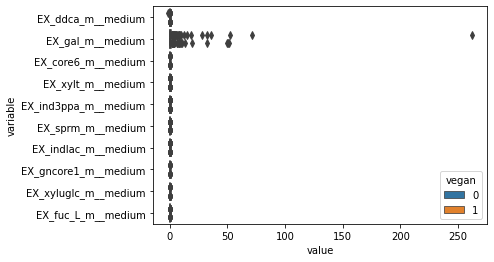

In [121]:
SAMPLE_NUM = 200
gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
X_flux_vegan, y_vegan_df = match_Xy_df(X_flux.copy(), gut_data.y_df)
# X_flux_vegan = mb_utils.scale_inputs(X_flux_vegan, pd_bool=True)
X_flux_vegan["vegan"] = y_vegan_df
## Convert to long
X_flux_vegan_long = X_flux_vegan.copy()
X_flux_vegan_long = X_flux_vegan_long.reset_index()

top_feats_df = get_top_df(imp_feat_flux_pheno_df,  col="vegan_flux",n_feats=5)
top_feats = top_feats_df.index

X_flux_vegan_long = pd.melt(
    X_flux_vegan_long, id_vars=["index","vegan"], 
    value_vars=top_feats
    #[
        #"EX_thr_L_m__medium", 
        # "EX_cgly_m__medium",
        # "EX_lcts_m__medium", "EX_isobut_m__medium", "EX_pect_m__medium"
        # "EX_salcn_m__medium", 
        # "EX_isocapr_m__medium", "EX_pcresol_m__medium"
        #]
        )
# sns.barplot(x="variable",y="value",hue="vegan",data=X_flux_vegan_long)
# sns.barplot(y="variable",x="value",hue="vegan",data=X_flux_vegan_long)
sns.boxplot(y="variable",x="value",hue="vegan",data=X_flux_vegan_long)

In [ ]:
flux_id = "EX_thr_L_m__medium"
fig, ax = plt.subplots(1)
X_flux_vegan[flux_id].loc[y_vegan_df[y_vegan_df==1].index].hist(ax=ax)
# X_flux_vegan[flux_id].loc[y_vegan_df[y_vegan_df==0].index].hist(ax=ax)

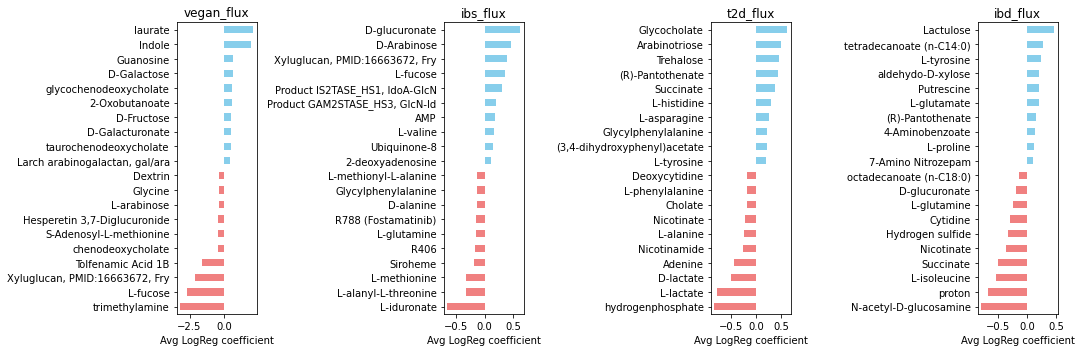

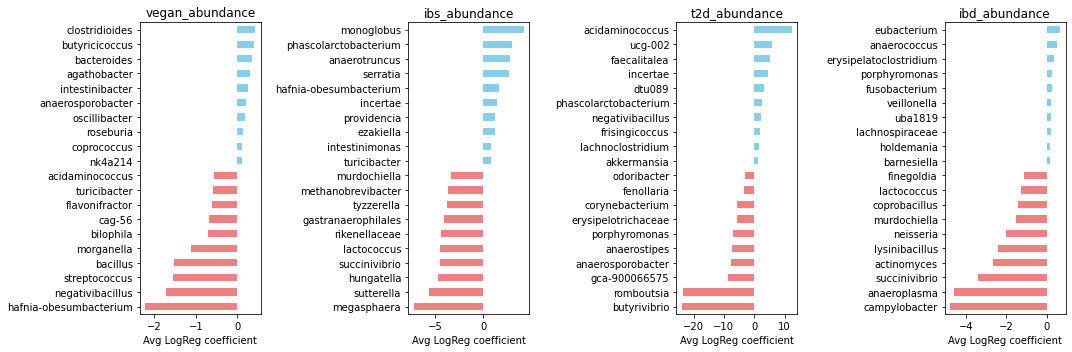

In [61]:
n_feats = 10

# for input_type, input_df in [("flux", imp_feat_flux_pheno_df), ("abundance", imp_feat_abundance_pheno_df)]:
for input_type, input_df in [("flux", imp_feat_flux_pheno_df_metab), ("abundance", imp_feat_abundance_pheno_df)]:

    f, ax = plt.subplots(1, len(input_df.columns), figsize=(15, n_feats/2)) # 5 works well for n_feats=10
    for i, col in enumerate(input_df.columns):
        top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
        top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
        top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
        top_df['positive'] = top_df[col] > 0
        top_df = top_df.sort_values(by=col,ascending=False)[::-1]
        top_df[col].plot(
            kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
        # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
        ax[i].set_xlabel("Avg LogReg coefficient")
        ax[i].set_title("%s"%(col))

    if SAVE_FIG == True:
        f.tight_layout()
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_barh_fd_%s.svg"%(input_type, SAVE_ID))
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_barh_fd_%s.png"%(input_type, SAVE_ID))

In [33]:
from scipy import stats

In [66]:
writer = pd.ExcelWriter(gut_data.dir_sim_data+'Z_SCORES_features.xlsx')

for input_type, input_df in [("flux", imp_feat_flux_pheno_df), ("abundance", imp_feat_abundance_pheno_df)]: # "flux", imp_feat_flux_pheno_df_metab

    #f, ax = plt.subplots(1, len(input_df.columns), figsize=(15, n_feats/2)) # 5 works well for n_feats=10
    for i, col in enumerate(input_df.columns):
        trait_input = col#+"_"+input_type
        z_scores = stats.zscore(input_df[trait_input], nan_policy="omit")
        z_scores = z_scores[z_scores.notnull()]
        p_values = stats.norm.sf(abs(z_scores.values))*2 #twosided - onesided *1
        p_values_df = pd.Series(p_values, index=z_scores.index)
        p_values_df_sig = p_values_df[p_values_df<0.05].sort_values()
        
        if col=="vegan":
            gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
        elif col=="ibs":
            gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
        elif col=="t2d":
            gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
        elif col=="ibd":
            gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
        
        SCALE_TYPE=StandardScaler()
        y_df = gut_data.y_df.copy()
        if input_type=="flux":
            X, y = match_Xy_df(X_flux.copy(), y_df)
        elif input_type=="abundance":
            X, y = match_Xy_df(gut_data.X_df.copy(), y_df)

        X_scale = SCALE_TYPE.fit_transform(X)
        f_stat, p_val = f_classif(X_scale, y)
        #fclass_df = pd.DataFrame(f_stat, index=X.columns, columns=["f_stat"])
        fclass_pval_df = pd.Series(p_val, index=X.columns)
        fclass_pval_df.name = "pval"
        # fclass_df = pd.DataFrame([f_stat, p_val], index=X.columns, columns=["f_stat", "p_val"])
        fclass_pval_df.sort_values()
        
        feat_means_dict = {}
        for feat_id in p_values_df_sig.index:
            
            #feat_id = "bacteroides"#"clostridioides"#"butyricicoccus"
            col_yes = X.loc[y[y==1].index][feat_id]
            col_no = X.loc[y[y==0].index][feat_id]
            # print(col_yes.mean(), col_no.mean())
            feat_means_dict.update({feat_id: {"yes": col_yes.mean(), "no": col_no.mean()}})
        
        p_values_df_sig = pd.DataFrame(p_values_df_sig)
        p_values_df_sig["yes"] = p_values_df_sig.index.map(lambda x: feat_means_dict[x]["yes"])
        p_values_df_sig["no"] = p_values_df_sig.index.map(lambda x: feat_means_dict[x]["no"])
        print(p_values_df_sig)
        
        p_values_df_sig.to_excel(writer, trait_input)
                
writer.save()

                                 0           yes            no
EX_fuc_L_m__medium    1.122714e-12  8.986533e-05  1.489419e-04
EX_xyluglc_m__medium  1.948153e-11 -1.693193e-06 -2.705450e-06
EX_ind3ppa_m__medium  1.980033e-10  7.781745e-08  9.683251e-08
EX_indlac_m__medium   1.750873e-05  1.505600e-07  1.896867e-07
EX_xylt_m__medium     3.112822e-04 -1.099905e-07 -2.070110e-07
EX_f1a_m__medium      4.224041e-03 -1.803093e-05 -2.115671e-05
EX_ddca_m__medium     1.010674e-02 -4.818034e-03 -1.797274e-02
EX_tma_m__medium      1.356620e-02  1.570057e-04  8.980655e-04
EX_gsn_m__medium      2.266200e-02 -1.977898e-02 -2.946746e-02
EX_gncore1_m__medium  3.925460e-02 -2.273584e-05 -2.596681e-05
                                 0           yes            no
EX_isomal_m__medium   1.951464e-13 -1.924831e-07 -2.230364e-07
EX_cellttr_m__medium  1.014710e-10 -1.973111e-07 -2.329077e-07
EX_galam_m__medium    6.130138e-10 -1.889253e-07 -2.084347e-07
EX_chitin_m__medium   8.402071e-05 -1.811180e-06 -2.087

In [63]:
p_values_df_sig["yes"] = "yes"

In [64]:
p_values_df_sig

EX_fuc_L_m__medium           0.0
EX_xyluglc_m__medium         0.0
EX_ind3ppa_m__medium         0.0
EX_indlac_m__medium     0.000018
EX_xylt_m__medium       0.000311
EX_f1a_m__medium        0.004224
EX_ddca_m__medium       0.010107
EX_tma_m__medium        0.013566
EX_gsn_m__medium        0.022662
EX_gncore1_m__medium    0.039255
EX_HC02192_m__medium    0.054523
EX_sprm_m__medium       0.083738
EX_Ser_Thr_m__medium    0.084098
EX_HC02193_m__medium    0.096221
yes                          yes
dtype: object

In [56]:
z_scores = stats.zscore(imp_feat_abundance_pheno_df["vegan_abundance"], nan_policy="omit")
z_scores = z_scores[z_scores.notnull()]
p_values = stats.norm.sf(abs(z_scores.values))*2 #twosided - onesided *1
p_values_df = pd.Series(p_values, index=z_scores.index)
p_values_df[p_values_df<0.1].sort_values()

hafnia-obesumbacterium    8.333558e-08
negativibacillus          9.211726e-06
streptococcus             7.776465e-04
bacillus                  1.113831e-03
morganella                2.131700e-02
dtype: float64

In [57]:
input_type = "abundance" # "flux"#"abundance"#"flux"

gut_data.set_vegan_df(sample_num=10000)
# gut_data.set_ibs_df(sample_num=10000, add_other_diagnosis=False)

SCALE_TYPE=StandardScaler()
y_df = gut_data.y_df.copy()
if input_type=="flux":
    X, y = match_Xy_df(X_flux.copy(), y_df)
elif input_type=="abundance":
    X, y = match_Xy_df(gut_data.X_df.copy(), y_df)

X_scale = SCALE_TYPE.fit_transform(X)
f_stat, p_val = f_classif(X_scale, y)
#fclass_df = pd.DataFrame(f_stat, index=X.columns, columns=["f_stat"])
fclass_pval_df = pd.Series(p_val, index=X.columns)
fclass_pval_df.name = "pval"
# fclass_df = pd.DataFrame([f_stat, p_val], index=X.columns, columns=["f_stat", "p_val"])
fclass_pval_df.sort_values()



3929.620481927711 4746.854281280857


In [ ]:
feat_id = "bacteroides"#"clostridioides"#"butyricicoccus"
col_yes = X.loc[y[y==1].index][feat_id]
col_no = X.loc[y[y==0].index][feat_id]
print(col_yes.mean(), col_no.mean())

In [32]:
stats.zscore(a)

NameError: name 'stats' is not defined

<AxesSubplot:>

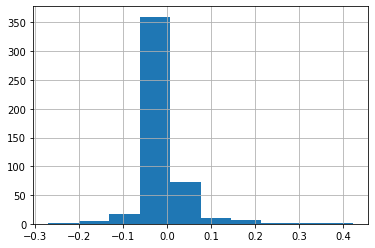

In [31]:
imp_feat_flux_pheno_df_metab["vegan_flux"].hist()

<AxesSubplot:>

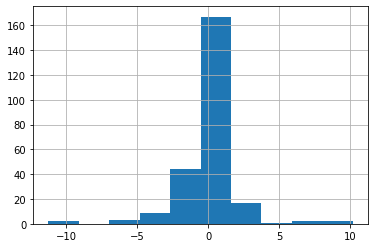

In [34]:
imp_feat_flux_pheno_df_metab["ibd_flux"].hist()

In [33]:
imp_feat_flux_pheno_df_metab["vegan_flux"].sort_values()[:10]

Konjac glucomannan, MW 77,500    -0.269110
5-Methyltetrahydrofolate         -0.164046
protein-linked serine or threo   -0.156004
trimethylamine                   -0.141031
L-asparagine                     -0.132211
Dimethyl sulfide                 -0.121711
2-deoxyadenosine                 -0.114640
3-methoxy-acetaminophen          -0.109310
L-fucose                         -0.096684
Cadmium                          -0.094811
Name: vegan_flux, dtype: float64

In [ ]:
n_feats = 10

# for input_type, input_df in [("flux", imp_feat_flux_pheno_df_metab), ("abundance", imp_feat_abundance_pheno_df)]:
for input_type, input_df in [("flux", flux_pheno_direct_df), ("abundance", imp_feat_abundance_pheno_df)]:

    f, ax = plt.subplots(1, len(input_df.columns), figsize=(10, n_feats/2)) # 5 works well for n_feats=10
    for i, col in enumerate(input_df.columns):
        top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
        top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
        top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
        top_df['positive'] = top_df[col] > 0
        top_df = top_df.sort_values(by=col,ascending=False)[::-1]
        top_df[col].plot(
            kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
        # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
        ax[i].set_xlabel("Avg LogReg coefficient")
        ax[i].set_title("%s"%(col))

    if SAVE_FIG == True:
        f.tight_layout()
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_direct_barh.svg"%(input_type))
        f.savefig(gut_data.dir_sim_data+"figures/"+"LogReg_%s_feature_direct_barh.png"%(input_type))

In [ ]:
X.columns[n_scores["estimator"][0]["selectkbest"].get_support()]

In [ ]:
def get_imp_feature_series(n_scores, FEAT_FILTER_TYPE, phenotype, input_type):
    feat_df = pd.DataFrame()

    for est_i in range(len(n_scores["estimator"])):
        if FEAT_FILTER_TYPE == "selectkbest":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE].get_support()],name=est_i)
        elif FEAT_FILTER_TYPE == "rfe":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE].support_],name=est_i)
        feat_df = pd.concat([feat_df, feat_series_df],axis=1)

    feat_df.fillna(0, inplace=True)
    feat_df_avg = feat_df.mean(axis=1)
    feat_df_avg.name = phenotype+"_"+input_type
    return feat_df_avg

# Metabolites to food interpretation
Plant based molecules terpenoids



In [ ]:
n_feats = 10
top_heatmap_df = pd.DataFrame()
for i, col in enumerate(imp_feat_flux_pheno_df.columns): # loop through flux_pheno
    top_df = get_top_df(imp_feat_flux_pheno_df_metab, col, n_feats=n_feats) # uses metab df for IDS or names
    top_heatmap_df = pd.concat([top_heatmap_df, top_df[[col]]],axis=1)

# top_heatmap_df

In [ ]:
flux_id = "EX_thr_L_m__medium"
# fig, ax = plt.subplots(1)
mean_1 = X_flux_vegan[flux_id].loc[y_vegan_df[y_vegan_df==1].index].mean()
mean_0 = X_flux_vegan[flux_id].loc[y_vegan_df[y_vegan_df==0].index].mean()
print(mean_1, mean_0)
# X_flux_vegan[flux_id].loc[y_vegan_df[y_vegan_df==0].index].hist(ax=ax)